# Dealing with WebbPSF

This is a personal introductory notebook for myself, because I have to learn use WebbPSF and this is probably the easiest way to do it.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import webbpsf
print('Currenlty running on WebbPSF', webbpsf.version.version)

Currenlty running on WebbPSF 0.7.0


## Generatinc coronagraphic PSFs

What is the main goal of this? I am currenlty translating Lucie Leboulleux' PASTIS algorithm from IDL to Python and in order to do that, I need to be able to simulate JWST PSFs with and without coronagraphic optics. So, for one I need to learn how to pick a coronagraphic configuration (masks, filter, etc.) and to display that and for the other I need to learn how to generate OPD maps that I need and recreate PSFs with that.
The notebooks on the WebbPSF GitHub are pretty neat, but also too much, so I will extract here what I need.

In [2]:
# Create a NIRCam object
nc = webbpsf.NIRCam()
nc.include_si_wfe = False   # This only gets explained further below... need to ask Marshall about this.

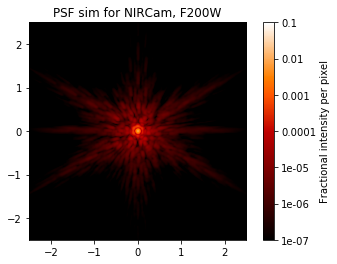

In [3]:
# Calculate the PSF of my current nc setup
psf = nc.calc_psf()
# Display the PSF
webbpsf.display_psf(psf)

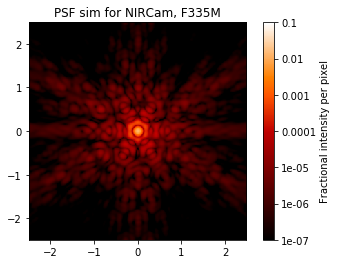

In [4]:
# Change the filter to what I want it to be
nc.filter = 'F335M'

# Recreate the PSF
psf = nc.calc_psf()
# And plot the nc PSF of the current setup
webbpsf.display_psf(psf)

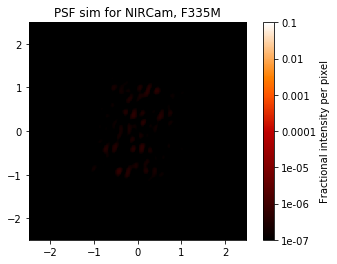

In [5]:
# Create a second NIRCam instrument case that will hold the coronagraph
nc_coro = webbpsf.NIRCam()
# Do the fix I need to ask Marshall about
nc_coro.include_si_wfe = False
# Add correct filter
nc_coro.filter = 'F335M'
# Add an occulting mask (focal plane mask)
nc_coro.image_mask = 'MASK335R'
# Add a Lyot stop in the pupil plane
nc_coro.pupil_mask = 'CIRCLYOT'

# Create the PSF
psf_coro = nc_coro.calc_psf()         # This takes quite a while.
# Display the new PSF
webbpsf.display_psf(psf_coro)

In [6]:
# To see what your options for generating the PSF are, check:
help(nc.calc_psf)

Help on method calc_psf in module webbpsf.webbpsf_core:

calc_psf(outfile=None, source=None, nlambda=None, monochromatic=None, fov_arcsec=None, fov_pixels=None, oversample=None, detector_oversample=None, fft_oversample=None, overwrite=True, display=False, save_intermediates=False, return_intermediates=False, normalize='first', add_distortion=True, crop_psf=True) method of webbpsf.webbpsf_core.NIRCam instance
    Compute a PSF.
    The result can either be written to disk (set outfile="filename") or else will be returned as
    a FITS HDUlist object.
    
    
    Output sampling may be specified in one of two ways:
    
    1) Set `oversample=<number>`. This will use that oversampling factor beyond detector pixels
       for output images, and beyond Nyquist sampling for any FFTs to prior optical planes.
    2) set `detector_oversample=<number>` and `fft_oversample=<other_number>`. This syntax lets
       you specify distinct oversampling factors for intermediate and final planes.
    

Type of psf_coro_im:  <class 'numpy.ndarray'>
Shape of psf_coro_im:  (316, 316)


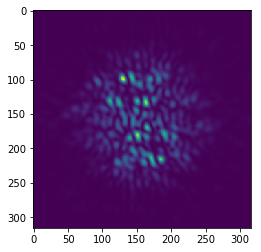

In [7]:
# The default return is the PSF as an HDUlist object, from which I can extract the data as an image array
# by doing this:
psf_coro_im = psf_coro[0].data
print('Type of psf_coro_im: ', type(psf_coro_im))
print('Shape of psf_coro_im: ', psf_coro_im.shape)

# Display it with classic plt.imshow().
plt.imshow(psf_coro_im)
plt.show()

In [8]:
# Since I will have to make the PSF a certain pixel size, I will use the keyword "fov_pixels" in calc_psf.
# We also don't want it to be oversampled with a factor of 4, which is default in webbpsf, but using ext='DET_SAMP'
# will give us an image sampled to the detector scale --> not working here. Does it goes somewhere else?
psf_coro = nc_coro.calc_psf(fov_pixels=150)   # --> Enter 150 to get it to 600 x 600 pixels.  # Taking a long time again.
                                    # Maybe this weird number got something to do with NIRCam having four modules?
psf = nc.calc_psf(fov_pixels=150)

print('PSF calculations done')

PSF calculations done


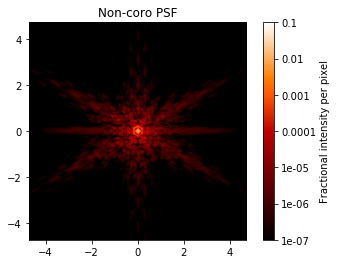

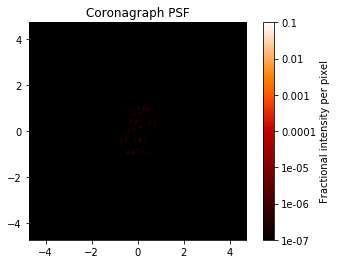

In [9]:
# Display both PSFs (without and with the coronagraph)
webbpsf.display_psf(psf)
plt.title('Non-coro PSF')
plt.show()
webbpsf.display_psf(psf_coro)
plt.title('Coronagraph PSF')
plt.show()

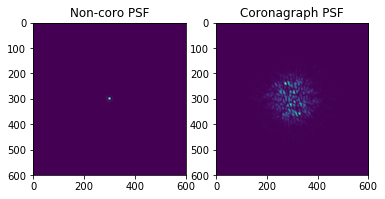

In [10]:
# Also, extract the PSFs as image arrays again
psf_im = psf[0].data
psf_coro_im = psf_coro[0].data

# Display them with plt.imshow()
plt.subplot(1,2,1)
plt.imshow(psf_im)
plt.title('Non-coro PSF')
plt.subplot(1,2,2)
plt.imshow(psf_coro_im)
plt.title('Coronagraph PSF')
plt.show()

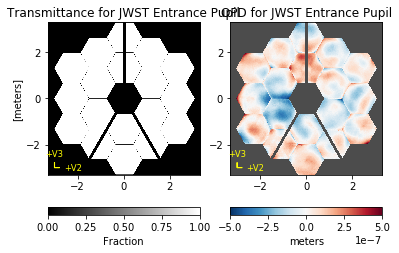

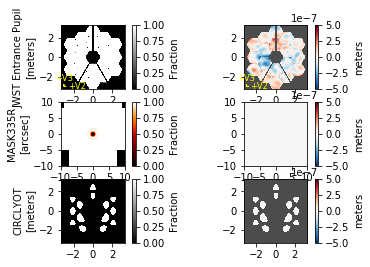

In [11]:
# Just in case you want to display all the planes in the optical train of your two instruments:
nc.display()
plt.show()

nc_coro.display()
plt.show()

## Working with OPD maps

Now that we know how to produce the PSFs we want, we also recquire to go in and change the OPD maps of the telescopes so that we can simulate the different configurations PASTIS needs.

Most helpful for this was:
https://github.com/mperrin/webbpsf/blob/master/notebooks/Simulated%20OTE%20Mirror%20Move%20Demo.ipynb

In [12]:
# List what OPD maps are available by default
print('Non-coro:\n', nc.opd_list)
print('Coro:\n', nc_coro.opd_list)

Non-coro:
 ['OPD_RevW_ote_for_NIRCam_predicted.fits.gz', 'OPD_RevW_ote_for_NIRCam_requirements.fits.gz']
Coro:
 ['OPD_RevW_ote_for_NIRCam_predicted.fits.gz', 'OPD_RevW_ote_for_NIRCam_requirements.fits.gz']


In [13]:
# The "requirements" OPD is used by default and is usually more conservative.
print('Non-coro:\n', nc.pupilopd)
print('Coro:\n', nc_coro.pupilopd)

Non-coro:
 OPD_RevW_ote_for_NIRCam_requirements.fits.gz
Coro:
 OPD_RevW_ote_for_NIRCam_requirements.fits.gz


While different OPD maps are used for each SI, these OPD maps do not include wavefront error contributions from optics internal to the science instrument.

NIRCam is one of the more complicated classes in webbpsf, and has several unique selectable options to model the two copies of NIRCam each with two channels.

The detector attribute can be used to select between any of the ten detectors, A1-A5 and B1-B5. Additional attributes are then automatically set for channel (“short” or “long”) and module (“A” or “B”) but these cannot be set directly; just set the desired detector and the channel and module are inferred automatically.

The choice of filter also impacts the channel selection: If you choose a long-wavelength filter such as F460M, then the detector will automatically switch to the long-wave detector for the current channel. 

In [14]:
# This means that we don't have to bother about chosing the right detector, our filter choice determines that for us:
print('Non-coro:\n', nc.detector)
print('Coro:\n', nc_coro.detector)

Non-coro:
 NRCA5
Coro:
 NRCA5



The contributions to wavefront error can be separated into:

1. OTE wavefront error (due to variations in the telescope optics common to all instruments)

2. static SI wavefront error (due to variations in the specific science instrument's optics)

3. field dependent SI wavefront error (due to variation in the PSF based on the position of the source within the field of view)

The first two components are combined in the pupilopd map shown in the top right panel. The last component of the model is generated at runtime from a Zernike coefficient lookup table. The include_si_wfe attribute switches this last component of the model on and off.

In [15]:
nc.include_si_wfe

False

In [16]:
# So if we want to include the SI WFE, we set it to:
nc.include_si_wfe = True
nc.include_si_wfe

True

In [17]:
# So lets check again what pupilopd map in the top right looks like:
nc.display()   # this will fail btw

RuntimeError: Could not find Zernike coefficients file in WebbPSF data directory

In [ ]:
# ... soooo... seems like there are no SI WFE files for NIRCam yet. Never mind, lets turn them off again then
# and we'll try to remember to use this feature in the future.
nc.include_si_wfe = False
nc.include_si_wfe

From GitHub:

"We can simulate JWST mirror adjustments using a linear optical model to adjust the optical path difference (OPD) array. This can be activated for a given WebbPSF instrument instance using the enable_adjustable_ote helper function. This notebook demonstrates a few things we can do with this."

In [ ]:
# Now, we want to be able to talk to the OTE (Optical Telescope Element, basically the general telescope with the
# mirror segments), so that we can adjust the segments with aberrations of whatever kind.
# So we will create the new object "ote", and we just need to tell webbpsf which instrument we will be using,
# so that it gets the ote details right for that instrument.
nc, ote = webbpsf.enable_adjustable_ote(nc)
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)

In [ ]:
# Take this function from https://github.com/mperrin/webbpsf/blob/master/notebooks/Simulated%20OTE%20Mirror%20Move%20Demo.ipynb
# It lets you display the current OTE setup and the resulting PSF. Pretty neat!

def display_ote_and_psf(inst, ote, opd_vmax=500, psf_vmax=0.01, title="OPD and PSF", **kwargs):
    psf = inst.calc_psf(monochromatic=3.35e-6)
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(121)
    ote.display_opd(ax=ax1, vmax=opd_vmax, 
                    colorbar_orientation='horizontal',
                   title='OPD modified for mirror moves') #, cbpad=0.05)
    ax2 = plt.subplot(122)
    webbpsf.display_psf(psf, ext=1, vmax=psf_vmax, vmin=psf_vmax/1e4,
                        colorbar_orientation='horizontal',
                       title="PSF sim, 3.35 microns") #, cbpad=0.05)
    plt.suptitle(title, fontsize=16)

In [ ]:
# Let's try it out:
display_ote_and_psf(nc, ote, title="Default OPD and PSF")
plt.show()
# 

display_ote_and_psf(nc_coro, ote_coro, title="Coronagraph OPD and PSF")
plt.show()

In [ ]:
# Let's see what the documentation says we can do wiht the OTE:
help(ote)
# It pays off to go back and see what the methods listed in the Methods resolution order are capable of doing.

In [ ]:
# For pastis, and for now, we're mainly interested in moving one segment at a time
# For PASTIS, I will have to map the segment names A1 thorugh C6 to the 18 segment numbers.

# Tilt one segment.
ote.reset()
ote_coro.reset()

ote.move_seg_local('A1', xtilt=.5)  # default units are microradians for tilts, microns for translations
ote_coro.move_seg_local('A1', xtilt=.5)

# Display it.
display_ote_and_psf(nc, ote, title="Perturbed default OPD and PSF")
display_ote_and_psf(nc_coro, ote_coro, title="Perturbed coronagraph OPD and PSF")

For PASTIS, I will probably also have to deal with coordinate system transformations, because (GitHub):

"A note about coordinate axes: The "control" coordinate system used for describing moves is not intuitive. Each segment has its own local X and Y axes, which are oriented differently for each of the A, B, and C segment types, and which rotate by 60 degrees for each successive segment of that type. Also, "Xtilt" means e.g. "tilt the segment around the local X axis" which results in a wavefront tilt that will move the PSF in the Y direction, and vice versa." 

In [ ]:
ote.reset()
ote_coro.reset()

ote.move_seg_local('A2', xtilt=.5)
ote_coro.move_seg_local('A2', xtilt=.5)

display_ote_and_psf(nc, ote, title="Perturbed default OPD and PSF")
display_ote_and_psf(nc_coro, ote_coro, title="Perturbed coronagraph OPD and PSF")